In [1]:
import pandas as pd
df = pd.read_csv('Rforest_defensas.csv')

df.head()

,value,age,X90s,Goals,Shots,SoT,SoT.,G.Sh,G.SoT,ShoDist,...,Off,Crs,PKwon,PKcon,OG,Recov,AerWon,AerLost,AerWon.,G.MP
0,7.0,23,3.0,0,0.67,0.33,50.0,0.0,0.0,7.8,...,0.00,1.33,0.0,0.0,0.0,6.00,1.00,2.00,33.3,0.0
1,6.0,26,8.4,0,0.36,0.12,33.3,0.0,0.0,25.1,...,0.00,2.62,0.0,0.0,0.0,3.57,1.43,1.07,57.1,0.0
2,8.0,23,1.6,0,2.50,1.25,50.0,0.0,0.0,10.5,...,0.00,0.00,0.0,0.0,0.0,6.88,0.00,0.63,0.0,0.0
3,50.0,20,13.4,0,0.45,0.15,33.3,0.0,0.0,22.6,...,0.15,1.42,0.0,0.0,0.0,6.27,0.37,0.75,33.3,0.0
4,3.0,24,3.1,0,1.29,0.32,25.0,0.0,0.0,26.4,...,0.00,1.94,0.0,0.0,0.0,4.52,1.94,0.97,66.7,0.0


# Mejores Hiperparámetros

In [2]:
# Búsqueda del mejor valor de cantidad de árboles, ajustado a la profundidad óptima encontrada (4)
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error, mean_absolute_percentage_error
import matplotlib.pyplot as plt
import plotly.express as px


seed = 123

X_train, X_test, y_train, y_test = train_test_split(df.drop(columns=['value']), df['value'], test_size=0.2, random_state=seed)


maxdepth_list = []
min_samples_list = []
nestimator_list = []
max_leaf_nodes_list = []
MAPE_test_list = []
MAE_CV_list = []

max_depth = [5, 10, 15]
min_samples_split = [2, 5, 10, 20]
max_leaf_nodes = [5, 10, 20, 30]
estimators = [50, 100, 200, 300]

for maxdepth in max_depth:
  for n_estimators in estimators:
    for samples in min_samples_split:
      for leaf_nodes in max_leaf_nodes:
        rf_model = RandomForestRegressor(random_state=seed, max_depth=maxdepth, n_estimators=n_estimators, min_samples_split=samples, max_leaf_nodes = leaf_nodes)
        rf_model.fit(X_train, y_train)
        y_pred = rf_model.predict(X_test)

        #cross validation CV = 3 / SCORE = MAE
        scores = cross_val_score(rf_model, X_train, y_train, cv=3,scoring='neg_mean_absolute_error')
        mae_scores = -scores

        ## Generación de listas
        maxdepth_list.append(maxdepth)
        nestimator_list.append(n_estimators)
        min_samples_list.append(samples)
        max_leaf_nodes_list.append(leaf_nodes)
        MAPE_test_list.append(mean_absolute_percentage_error(y_test,y_pred))
        MAE_CV_list.append(mae_scores.mean()) # MAE

        df_grid = pd.DataFrame({"maxdepth":maxdepth_list,
                          "n_estimators":nestimator_list,
                           "min_samples":min_samples_list,
                           "max_leaf_nodes":max_leaf_nodes_list,
                           "MAPE_test":MAPE_test_list,
                            "MAE_CV":MAE_CV_list})

fig = px.scatter_3d(df_grid, x='MAE_CV', y='max_leaf_nodes', z='maxdepth', color='min_samples', size='n_estimators')
fig.update_layout(
    title="Hyperparameter tuning Defensas",
    autosize=True, width=900, height=900,
    margin = dict(l=65, r=50, b=65, t=90))
fig.show()
min_mae = df_grid["MAE_CV"].idxmin()
print('Los hiperparámetros ajustados al mínimo MAE son:')
print(df_grid.loc[min_mae])

Los hiperparámetros ajustados al mínimo MAE son:
maxdepth            5.000000
n_estimators      100.000000
min_samples        10.000000
max_leaf_nodes      5.000000
MAPE_test           1.159679
MAE_CV             10.114781
Name: 24, dtype: float64


In [3]:
fig = px.scatter(df_grid, x="MAE_CV", y="max_leaf_nodes", color="maxdepth",
                 size='min_samples', symbol = 'n_estimators')

fig.update_layout(
    title="Hyperparameter tuning (Defensas)",
    autosize=True,
    width=900,
    height=700,
    margin=dict(l=65, r=50, b=65, t=90),
    legend=dict(orientation="h", x=0.5, y=1.1),
    xaxis_title="Mean Absolute Error (CV)",
    yaxis_title="Max Leaf Nodes",
    coloraxis_colorbar_title="Max Depth",
    showlegend=True
)

fig.show()

# Mejor Modelo

In [4]:
# Mejores hiperparámetros
best_params_x = {
    'max_depth': 5,
    'max_leaf_nodes': 5,
    'min_samples_split': 10,
    'n_estimators': 100
}

# Crear el mejor modelo
best_rf_model= RandomForestRegressor(random_state=123, **best_params_x)

# Ajustar el modelo a los datos de entrenamiento
best_rf_model.fit(X_train, y_train)

# Calcular el MAE para los datos de entrenamiento
y_pred_train = best_rf_model.predict(X_train)
mae_train = mean_absolute_error(y_train, y_pred_train)

# Calcular el MAE para los datos de prueba
y_pred_test = best_rf_model.predict(X_test)
mae_test= mean_absolute_error(y_test, y_pred_test)

# Calcular el MAPE para los datos de entrenamiento y prueba
mape_train = mean_absolute_percentage_error(y_train, y_pred_train) * 100  # Multiplicado por 100 para convertirlo a porcentaje
mape_test = mean_absolute_percentage_error(y_test, y_pred_test) * 100  # Multiplicado por 100 para convertirlo a porcentaje

# Imprimir el MAE y el MAPE para la Iteración 2

print(f"MAE de entrenamiento: {mae_train}")
print(f"MAE de prueba: {mae_test}")
print(f"MAPE de entrenamiento (%): {mape_train}")
print(f"MAPE de prueba (%): {mape_test}")

MAE de entrenamiento: 8.548159831816776
MAE de prueba: 10.961511491166485
MAPE de entrenamiento (%): 101.81917333248325
MAPE de prueba (%): 115.96791716494927


# Importancia de las Variables

In [5]:
!pip install shap

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 535.7/535.7 kB 6.4 MB/s eta 0:00:00


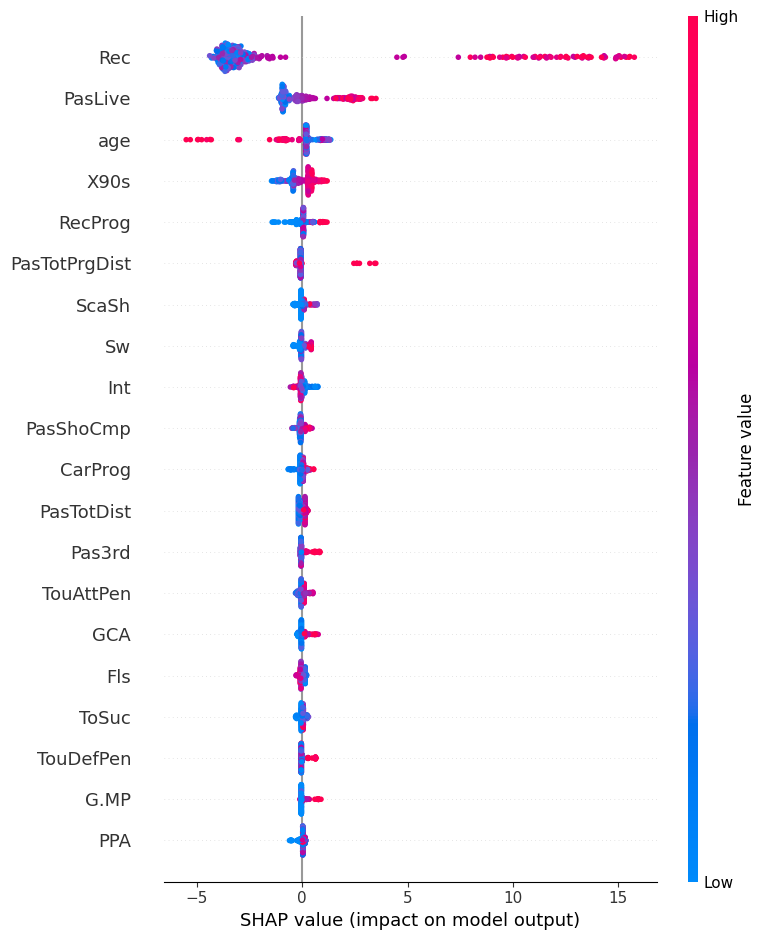

In [6]:
# Importa la biblioteca SHAP

import shap

# Crear un objeto explicador SHAP con el mejor modelo
explainer = shap.Explainer(best_rf_model)

# Calcular los valores SHAP para el conjunto de entrenamiento
shap_values = explainer.shap_values(X_train)

# Graficar un resumen de los valores SHAP
shap.summary_plot(shap_values, X_train)

# Predicciones

In [7]:
predicciones = best_rf_model.predict(df.drop(columns=['value']))
df['value_pred'] = predicciones
df.head()

,value,age,X90s,Goals,Shots,SoT,SoT.,G.Sh,G.SoT,ShoDist,...,Crs,PKwon,PKcon,OG,Recov,AerWon,AerLost,AerWon.,G.MP,value_pred
0,7.0,23,3.0,0,0.67,0.33,50.0,0.0,0.0,7.8,...,1.33,0.0,0.0,0.0,6.00,1.00,2.00,33.3,0.0,11.117959
1,6.0,26,8.4,0,0.36,0.12,33.3,0.0,0.0,25.1,...,2.62,0.0,0.0,0.0,3.57,1.43,1.07,57.1,0.0,11.029147
2,8.0,23,1.6,0,2.50,1.25,50.0,0.0,0.0,10.5,...,0.00,0.0,0.0,0.0,6.88,0.00,0.63,0.0,0.0,11.797580
3,50.0,20,13.4,0,0.45,0.15,33.3,0.0,0.0,22.6,...,1.42,0.0,0.0,0.0,6.27,0.37,0.75,33.3,0.0,37.733450
4,3.0,24,3.1,0,1.29,0.32,25.0,0.0,0.0,26.4,...,1.94,0.0,0.0,0.0,4.52,1.94,0.97,66.7,0.0,11.029147


# Jugadores sobre / sub valorados

In [8]:
df['diferencia'] = df['value_pred']-df['value']

df['valorizacion'] = np.where(df['diferencia']>11,'Subvalorado',np.where(df['diferencia']<-11,'Sobrevalorado',''))
df.head(50)
#df[df['valorizacion'] == 'Sobrevalorado'].count()


,value,age,X90s,Goals,Shots,SoT,SoT.,G.Sh,G.SoT,ShoDist,...,PKcon,OG,Recov,AerWon,AerLost,AerWon.,G.MP,value_pred,diferencia,valorizacion
0,7.0,23,3.0,0,0.67,0.33,50.0,0.00,0.00,7.8,...,0.00,0.00,6.00,1.00,2.00,33.3,0.000000,11.117959,4.117959,
1,6.0,26,8.4,0,0.36,0.12,33.3,0.00,0.00,25.1,...,0.00,0.00,3.57,1.43,1.07,57.1,0.000000,11.029147,5.029147,
2,8.0,23,1.6,0,2.50,1.25,50.0,0.00,0.00,10.5,...,0.00,0.00,6.88,0.00,0.63,0.0,0.000000,11.797580,3.797580,
3,50.0,20,13.4,0,0.45,0.15,33.3,0.00,0.00,22.6,...,0.00,0.00,6.27,0.37,0.75,33.3,0.000000,37.733450,-12.266550,Sobrevalorado
4,3.0,24,3.1,0,1.29,0.32,25.0,0.00,0.00,26.4,...,0.00,0.00,4.52,1.94,0.97,66.7,0.000000,11.029147,8.029147,
5,3.5,31,19.7,0,0.56,0.05,9.1,0.00,0.00,25.5,...,0.10,0.00,6.24,0.76,0.96,44.1,0.000000,11.578871,8.078871,
6,12.0,27,9.3,0,1.61,0.65,40.0,0.00,0.00,17.8,...,0.00,0.00,4.09,0.97,0.86,52.9,0.000000,12.142604,0.142604,
7,4.0,27,8.2,0,0.73,0.00,0.0,0.00,0.00,23.4,...,0.00,0.00,3.78,0.61,1.71,26.3,0.000000,11.347196,7.347196,
8,40.0,27,8.0,0,0.38,0.25,66.7,0.00,0.00,15.9,...,0.00,0.00,6.13,2.38,1.00,70.4,0.000000,34.041287,-5.958713,
9,32.0,30,13.6,1,1.03,0.22,21.4,0.07,0.33,13.3,...,0.00,0.00,5.51,1.62,0.59,73.3,0.073529,21.430876,-10.569124,


# Gráfico comparativo valor real vs predicción

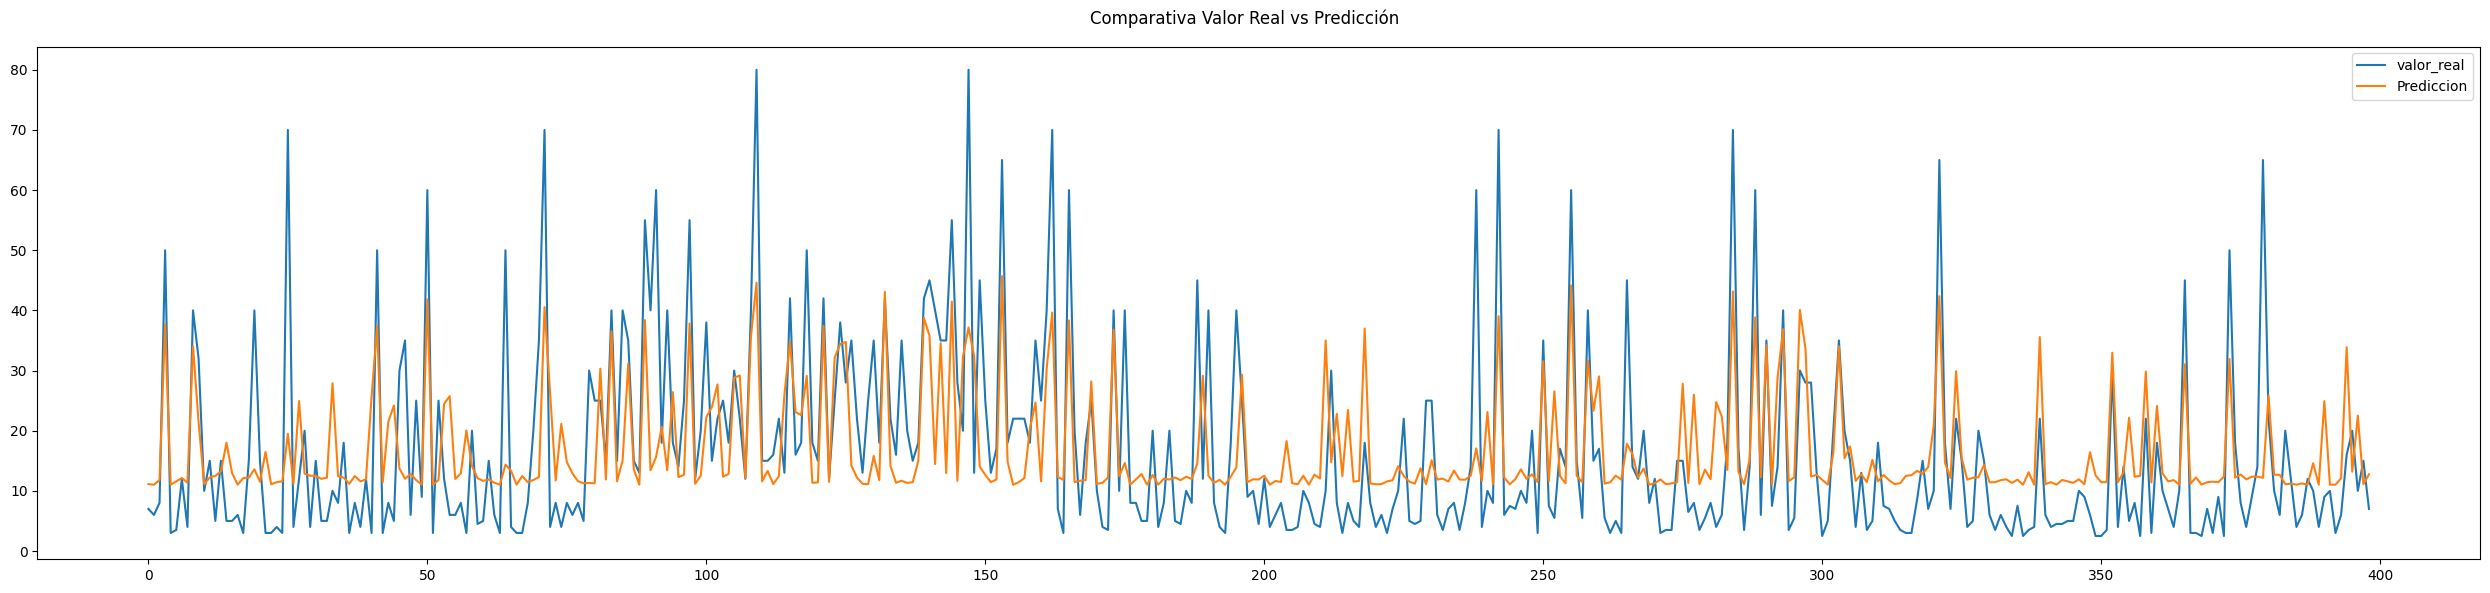

In [9]:
plt.figure(figsize=(25, 6))
df["value"].plot(label="valor_real")
df["value_pred"].plot(label="Prediccion")

plt.suptitle("Comparativa Valor Real vs Predicción")
plt.legend()
plt.tight_layout()
plt.show();

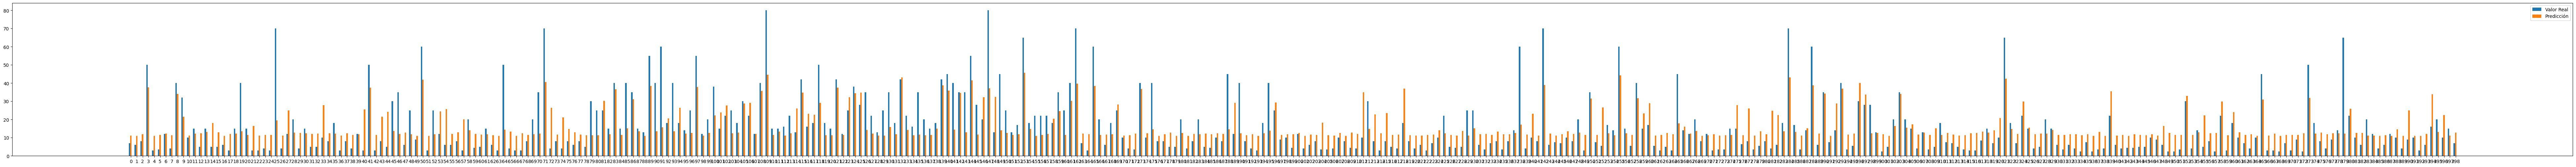

In [10]:
import numpy as np

n = len(df.index)
x = np.arange(n)
width = 0.25
plt.figure(figsize=(100, 6))
plt.bar(x - width, df.value, width=width, label='Valor Real')
plt.bar(x, df.value_pred, width=width, label='Predicción')
plt.xticks(x, df.index)
plt.legend(loc='best')
plt.show()